# Anomaly Detection with Isolation Forest

### Notes from Infosec's Cybersecurity Data Science Learning Path
* <u>Isolation Forest</u>: anomaly detection algorithm. Uses trees to describe points, and those points that are EASILY DESCRIBED: are anomalous.
* <u>Anomaly Detection</u>: identifying rare events that raise suspicion by differing significantly from most of the data
    * Advantage - can detect previously unseen (zero-day) events
* <u>Decision function</u>: the number of splittings of the trees required to describe a point. The larger this number, the more "normal" the point.

In [1]:
## Simple Example with made up data ##
#two distributions: one normal, one anomalous

import numpy as np
rng = np.random.RandomState(42)
nNorm = 2000
nAnom = 200
X_norm = np.r_[0.5 * rng.randn(int(nNorm/2), 2), 0.5 * rng.randn(int(nNorm/2), 2)]
y_norm = nNorm * [0]
X_anom = rng.uniform(low=-5, high=5, size=(nAnom, 2))
y_anom = nAnom*[1]

In [2]:
#Print data for normal data
print(X_norm.shape)
print(X_norm[0:5])

(2000, 2)
[[ 0.24835708 -0.06913215]
 [ 0.32384427  0.76151493]
 [-0.11707669 -0.11706848]
 [ 0.78960641  0.38371736]
 [-0.23473719  0.27128002]]


In [3]:
#Print data for anomalous data
print(X_anom.shape)
print(X_anom[0:5])

(200, 2)
[[-0.14982012 -4.1459697 ]
 [ 4.7246139   0.18010431]
 [ 1.14186244 -2.63390217]
 [-0.16501915 -0.70850508]
 [-4.25104158 -3.93839646]]


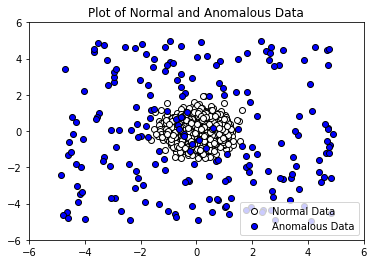

In [4]:
#Plot these points
%matplotlib inline
import matplotlib.pyplot as plt

p_norm = plt.scatter(X_norm[:,0], X_norm[:,1], c ='white', edgecolor = 'black')
p_anom = plt.scatter(X_anom[:,0], X_anom[:,1], c ='blue', edgecolor = 'black')

plt.title("Plot of Normal and Anomalous Data")
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.legend([p_norm,p_anom],
          ["Normal Data", "Anomalous Data"],
          loc="lower right")
plt.show() #some anomalous data seem completely "normal"

In [5]:
#Create a train/test split
#put both normal and anomalous data into the training dataset

from sklearn.model_selection import train_test_split
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size = 0.2)
X_anom_train, X_anom_test, y_anom_train, y_anom_test = train_test_split(X_anom, y_anom, test_size = 0.2)
X_train = np.concatenate([X_norm_train, X_anom_train])
y_train = np.concatenate([y_norm_train, y_anom_train])
X_test = np.concatenate([X_norm_test, X_anom_test])
y_test = np.concatenate([y_norm_test, y_anom_test])

In [6]:
#Build the Isolation Forest Model
from sklearn.ensemble import IsolationForest
clf = IsolationForest()
clf.fit(X_train) #fit model on training data

C:\Users\604906\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\604906\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Distribution of Anomaly Scores for Normal Training Data')

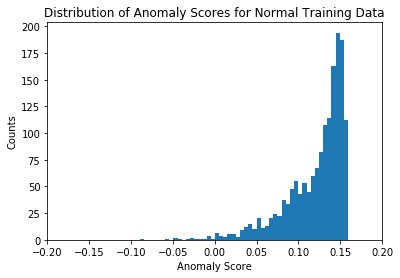

In [7]:
#Compute the decision function of all the "normal" part of the training data
train_scores = clf.decision_function(X_norm_train)
plt.hist(train_scores, bins = 50) # adding "density = True" option converts counts -> probability density (Area under hist: 1)
plt.xlim(-0.2, 0.2)
plt.xlabel('Anomaly Score')
plt.ylabel('Counts')
plt.title("Distribution of Anomaly Scores for Normal Training Data")

Text(0.5, 1.0, 'Distribution of Anomaly Scores for Anomalous Training Data')

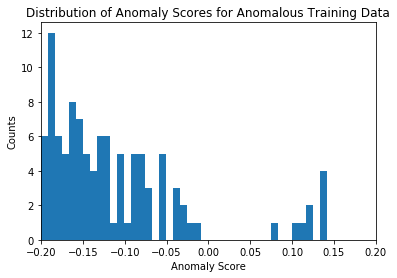

In [8]:
#Do the same for the anomalous training data
train_scores = clf.decision_function(X_anom_train)
plt.hist(train_scores, bins = 50)
plt.xlim(-0.2, 0.2) #use the same X axis as above
plt.xlabel('Anomaly Score')
plt.ylabel('Counts')
plt.title("Distribution of Anomaly Scores for Anomalous Training Data")

In [9]:
#How do we separate the two to distinguish normal vs. anomalous?
#Use a cutoff point of "0.0" by visual inspection 
cutoff = 0.0

In [10]:
#Score the model
def FPR(y_true, y_pred): # normal point misclassified as anomalous : "false alarm"
    Tot_Neg = sum(y_true == 0)
    FP = sum(y_pred[y_true == 0] == 1)
    return str(float(FP)/float(Tot_Neg)*100) + "%"

def TPR(y_true, y_pred): # anomalous point correctly classified as anomalous
    Tot_Pos = sum(y_true == 1)
    TP = sum(y_pred[y_true == 1] == 1)
    return str(float(TP)/float(Tot_Pos)*100) + "%"

In [11]:
#Compute these two metrics using the cutoff of 0.0
#for the training set
print(FPR(y_train, (cutoff > clf.decision_function(X_train)).astype(int))) #FPR ~ 1.0%
print(TPR(y_train, (cutoff > clf.decision_function(X_train)).astype(int))) #correctly captures ~ 94% of anomalies

1.0%
94.375%


In [12]:
#Do the same for the test set
print(FPR(y_test, (cutoff > clf.decision_function(X_test)).astype(int))) #FPR ~ 0.75%
print(TPR(y_test, (cutoff > clf.decision_function(X_test)).astype(int))) #correctly captures ~ 90% of anomalies

0.75%
90.0%


## Practice with another Dataset
*Utilizing the credit card fraud dataset which can be found in <b>Kaggle</b>: [link](https://www.kaggle.com/mlg-ulb/creditcardfraud)*
* <u>Background</u>: The dataset includes valid and fraudulent transactions, where 492 are fraudulent (0.172%) out of 284,807 total.
* <u>Features</u>: Time (seconds elapsed between each transaction and first transaction in the data), Amount (Transaction Amount), V1-V28 (principal components generated by PCA), Class (fraud indicator).

In [13]:
import pandas as pd
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
#separate out data and labels
X_norm = df[df.Class == 0].drop(['Class'], axis=1)
y_norm = df[df.Class == 0]['Class']
X_anom = df[df.Class == 1].drop(['Class'], axis=1)
y_anom = df[df.Class == 1]['Class']

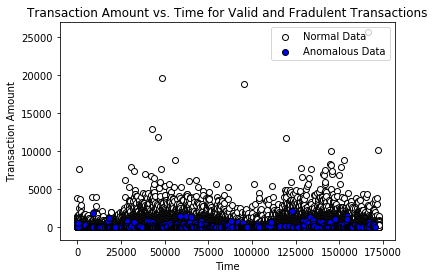

In [15]:
#Plot transactions amt vs. time for both fraudulent & valid transactions
%matplotlib inline
import matplotlib.pyplot as plt

p_norm = plt.scatter(X_norm['Time'], X_norm['Amount'], c ='white', edgecolor = 'black')
p_anom = plt.scatter(X_anom['Time'], X_anom['Amount'], c ='blue', edgecolor = 'black')

plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.title("Transaction Amount vs. Time for Valid and Fradulent Transactions")
plt.legend([p_norm,p_anom],["Normal Data", "Anomalous Data"], loc="upper right")
plt.show() #not too many insights here

In [16]:
#Let's look at the mean amount for valid vs. fraud transactions
X_norm['Amount'].describe() #mean amt: 88

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
X_anom['Amount'].describe() #mean amt: 122, higher on average despite the class imbalance.
#max fraud transaction ~ 2000

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [18]:
#Similar to the previous example, create a train test split, making sure to include both valid and fraud in the training set.

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size = 0.2)
X_anom_train, X_anom_test, y_anom_train, y_anom_test = train_test_split(X_anom, y_anom, test_size = 0.2)
X_train = np.concatenate([X_norm_train, X_anom_train])
y_train = np.concatenate([y_norm_train, y_anom_train])
X_test = np.concatenate([X_norm_test, X_anom_test])
y_test = np.concatenate([y_norm_test, y_anom_test])

In [19]:
#Build the Isolation Forest Model
from sklearn.ensemble import IsolationForest
clf = IsolationForest()
clf.fit(X_train) #fit model on training data

C:\Users\604906\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\604906\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Distribution of Anomaly Scores for Valid Transactions')

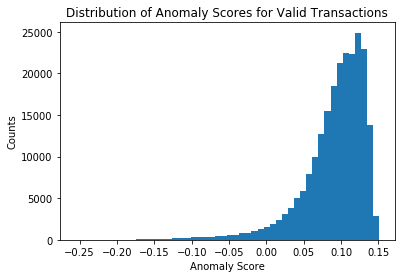

In [20]:
#Compute the decision function for all valid transactions
train_scores = clf.decision_function(X_norm_train)
plt.hist(train_scores, bins=50) 
plt.xlabel('Anomaly Score')
plt.ylabel('Counts')
plt.title("Distribution of Anomaly Scores for Valid Transactions")

Text(0.5, 1.0, 'Distribution of Anomaly Scores for Fraudulent Transactions')

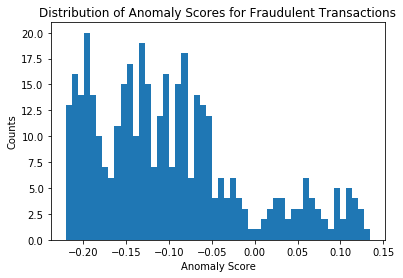

In [21]:
#Do the same for Fraudulent Transactions
train_scores = clf.decision_function(X_anom_train)
plt.hist(train_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Counts')
plt.title("Distribution of Anomaly Scores for Fraudulent Transactions")

In [22]:
#Play around with the cutoff threshold (threshold picked: 0.03)
cutoff = 0.03

In [23]:
#Using the FPR and TPR functions generated earlier, compute the FPR and TPR
#In this case, having a better TPR > having a better FPR
print(FPR(y_train, (cutoff > clf.decision_function(X_train)).astype(int))) #FPR ~ 8%
print(TPR(y_train, (cutoff > clf.decision_function(X_train)).astype(int))) #correctly captures ~ 88% of fraudulent transactions

7.878585371858677%
88.29516539440203%


In [24]:
#Do the same for the test set
print(FPR(y_test, (cutoff > clf.decision_function(X_test)).astype(int))) #FPR ~ 8%
print(TPR(y_test, (cutoff > clf.decision_function(X_test)).astype(int))) #correctly captures ~ 87% of fraudulent transactions

7.8645164694089305%
86.86868686868688%


## Conclusion
* Isolation Forest is an anomaly detection algorithm that computes "anomaly scores" for each data point.
* Isolation Forest can be used in fraud detection, predictive maintenance, and cybersecurity data.
